##Import packages & load data

In [1]:
import pandas as pd
import numpy as np
from numpy import where

!pip install autoimpute
from autoimpute.imputations import SingleImputer

import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, Lasso, SGDRegressor
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Hyperparameter Tuning Packages
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, TimeSeriesSplit

from xgboost import plot_importance
!pip install shap
import shap

     |████████████████████████████████| 102kB 4.1MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 358kB 4.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491635 sha256=e71022545e76d9978dfc2565ada1d1acc2e279fed647e40f1d32620247e2493b
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the excel dataset
df = pd.read_excel('/content/drive/MyDrive/MMAI/Finance/Alfred_Dataset.xlsx')

In [5]:
# check sample
print(df.shape)
df.head(3)

(180, 37)


,Date,Target_GreaterToronto_Single_Family_HPI,1Yr_MetroOntario_CPI_All,1M_MetroOntario_CPI_all,1Yr_MetroOntario_CPI_Shelter,1M_MetroOntario_CPI_Shelter,Month,1Yr_Lag,1M_Lag,1Yr_GreaterVancounver_Single_Family_HPI,1M_GreaterVancounver_Single_Family_HPI,1Yr_Calgary_Single_Family_HPI,1M_Calgary_Single_Family_HPI,1Yr_Montreal_Single_Family_HPI,1M_Montreal_Single_Family_HPI,1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice,1Yr_RetailSales_Toronto,1M_RetailSales_Toronto,1M_Avg_Temperature,1Yr_Avg_Temp,1M_Snow_onGround,1Yr_Snow_onGround,1Yr_Toronto_Median_Annual_Income_Couple_Families,1Yr_Toronto_Median_Annual_Income_Lone_Parent_Families,1M_Toronto_ConstructionCompletionsUnits,1Yr_Toronto_ConstructionCompletionsUnits,1M_Toronto_ConstructionStartsUnits,1Yr_Toronto_ConstructionStartsUnits,1M_Toronto_UnempRate_15_54_yrs,1Yr_BankRate_Canada,1M_BankRate_Canada,1M_Population,1Y_S&P500_Close,1M_S&P500_Close,1Y_Bachelors_Degree_Ontario_NewRegEducation,1Y_Bachelors_Degree_Ontario_NewRegAll
0,2006-01-01,106.4,105.1,107.6,107.4,110.2,1,100.0,105.7,100.0,110.4,100.0,114.7,100.0,103.8,14281,119542,4437136,4486253,-3.446452,-6.829677,1.348387,1.070968,69900.0,31600.0,3296,3173,3401,1681,NaN,2.75,3.50,5035000.000,1181.27,1248.29,11928,333234
1,2006-02-01,107.4,105.8,108.2,107.9,111.7,2,101.3,106.4,100.5,112.6,101.1,118.9,100.9,104.7,14336,125963,4479503,4528948,0.200000,-3.995000,0.251613,1.192857,69900.0,31600.0,4427,2761,2660,2296,NaN,2.75,3.75,5042500.000,1203.60,1280.08,11928,333234
2,2006-03-01,108.7,106.4,107.9,108.2,112.0,3,102.4,107.4,101.1,114.8,102.6,125.7,101.9,106.4,14601,124172,4376561,4556689,-3.567500,-1.621290,0.771429,0.825806,69900.0,31600.0,2882,5443,1539,2941,NaN,2.75,3.75,5050011.172,1180.59,1280.66,11928,333234


In [32]:
# New column for date year
df['Year'] = df['Date'].dt.year
# drop a silly feature
df = df.drop(columns='1Y_Bachelors_Degree_Ontario_NewRegEducation')

In [65]:
df.columns

Index(['Date', 'Target_GreaterToronto_Single_Family_HPI',
       '1Yr_MetroOntario_CPI_All', '1M_MetroOntario_CPI_all',
       '1Yr_MetroOntario_CPI_Shelter', '1M_MetroOntario_CPI_Shelter', 'Month',
       '1Yr_Lag', '1M_Lag', '1Yr_GreaterVancounver_Single_Family_HPI',
       '1M_GreaterVancounver_Single_Family_HPI',
       '1Yr_Calgary_Single_Family_HPI', '1M_Calgary_Single_Family_HPI',
       '1Yr_Montreal_Single_Family_HPI', '1M_Montreal_Single_Family_HPI',
       '1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
       '1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice',
       '1Yr_RetailSales_Toronto', '1M_RetailSales_Toronto',
       '1M_Avg_Temperature', '1Yr_Avg_Temp', '1M_Snow_onGround',
       '1Yr_Snow_onGround', '1Yr_Toronto_Median_Annual_Income_Couple_Families',
       '1Yr_Toronto_Median_Annual_Income_Lone_Parent_Families',
       '1M_Toronto_ConstructionCompletionsUnits',
       '1Yr_Toronto_ConstructionCompletionsUnits',
       '1M_Toronto_ConstructionStartsU

#**Modeling**

#Functions

In [66]:
def clean_data(df):
   
    clean_X = df.drop(['Target_GreaterToronto_Single_Family_HPI'], axis=1)
    clean_Y = df['Target_GreaterToronto_Single_Family_HPI']
    
    return clean_X, clean_Y

def split_data(clean_X, clean_Y, train_size):
    row_num = int(clean_X.shape[0]*train_size)
    
    X_train = clean_X[:row_num].drop(['Date'], axis=1)
    Y_train = clean_Y[:row_num]
    
    X_test  = clean_X[row_num:].drop(['Date'], axis=1)
    Y_test  = clean_Y[row_num:]

    X_test_date  = clean_X[row_num:][['Date']]

    imputer = SingleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    return X_train, X_test, Y_train, Y_test, X_test_date

def adj_r2(X, y, y_pred):
        r2 = r2_score(y,y_pred)
        adj_r2 = (1 - (1 - r2) * ((X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1)))
        return r2, adj_r2

def predict_test_values(model, X_test, y_test, X_test_date, X_train, y_train):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    y_test_pred_rmse = mean_squared_error(y_test,y_test_pred,squared=False)
    print (f'RMSE of Test Data: {y_test_pred_rmse}')
    
    r2_train, adj_r2_train = adj_r2(X_train, y_train,y_train_pred)
    r2_test, adj_r2_test = adj_r2(X_test, y_test, y_test_pred)
    
    print (f'Adjusted R2 of Train Data: {adj_r2_train}')
    print (f'R2 of Test Data: {r2_test}')
    
    #Populate dataframe for plotting
    df_test_actual = pd.DataFrame(y_test).rename({'TARGET':'y_test_actual'},axis=1).reset_index(drop=True)
    df_test_pred = pd.DataFrame(y_test_pred,columns=['y_test_pred']).reset_index(drop=True)
    df_test = pd.concat([X_test_date.reset_index(drop=True),df_test_actual,df_test_pred],axis=1)
    
    #Group results
    df_test_results = df_test.groupby(['Date']).sum()
    
    return df_test_results

def plot_test_results (df_test_results, model_num):
    
    model_names = {
    1: 'XGBoost',
    2: 'Bayesian',
    3: 'ARD Regression',
    4: 'Linear Regression',   
    5: 'Lasso',
    6: 'SGD'
    }
    title = model_names[model_num] + ' Actual vs. Model Results'
    
    plt.plot(df_test_results.index, df_test_results)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(['Actual GreaterToronto_Single_Family_HPI','Predicted GreaterToronto_Single_Family_HPI']) 
    plt.grid(False)
    return plt.show()

def residual_plot(model,X, Y, hist=False,qqplot=True):
    """
    Plot *residual* to understand Homoscedasticity and heteroskedasticity
    Plot *q-q* plot for normality testing
    """
    visualizer = ResidualsPlot(model,hist=hist, qqplot=qqplot)
    visualizer.fit(X, Y) 
    return visualizer.show()

def feat_selection_step_1(model_num, X_train, y_train, X_test, y_test, top):
    """
    First stage of feature selection. Sort all faetures by predicitve power,
    by testing performance of features individually on predicting the target
    """
    rmse_score = []
    for i in range(0,len(X_train.columns)):
        X_train_samp = X_train.iloc[:, [i]]
        X_test_samp = X_test.iloc[:, [i]]
        model = models[model_num].fit(X_train_samp,y_train)
        y_test_pred = model.predict(X_test_samp)
        y_test_pred_rmse = mean_squared_error(y_test,y_test_pred,squared=False)
        rmse_score.append(y_test_pred_rmse)
        
    feature_rank = pd.DataFrame(list(zip(X_train.columns,rmse_score)), columns=['col_name','rmse_score'])
    feature_rank = feature_rank.sort_values('rmse_score')
    
    feature_rank = feature_rank.head(top)
    
    pd.set_option('display.max_rows', top)
    display(feature_rank)
    pd.set_option('display.max_rows', 20)
    
    
    X_train = X_train[list(feature_rank.col_name)]
    X_test  = X_test[list(feature_rank.col_name)]
    
    return feature_rank, X_train, X_test

def feat_selection_step_2(train_data, test_data, threshold):
    """
    Second stage of feature selection, using the top 50 features from stage 1, find the 
    single highest correlated feature to each of the 50 features using pearsons r.
    
    Remove cols higher then threshold.
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = train_data.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in train_data.columns:
                    #if colname not in ['WEEK_START_DATE_MONTH','WEEK_END_DATE_MONTH','WEEK_START_DATE_WEEK','WEEK_END_DATE_WEEK']:
                    if colname not in ['Year']:
                        print('Dropped:', colname)
                        del train_data[colname] # deleting the column from the dataset
                        del test_data[colname]
        
    
    return train_data, test_data


def tuner(params, folds, model, X_train, y_train):
    """
        Do a k fold hyperparamter tune using random search
    """
    
    kf = TimeSeriesSplit(n_splits=folds)
    
    random_search = RandomizedSearchCV(model, param_distributions=params, 
                                    n_iter=len(params), scoring='neg_root_mean_squared_error', n_jobs=4,
                                       cv=kf.split(X_train,y_train), verbose=3, random_state=1001)
    random_search.fit(X_train, y_train)
    
    print('\nBest hyperparameters: ', random_search.best_params_, "\nBest Score: ", random_search.best_score_)

    return random_search.best_params_, random_search.best_estimator_

In [67]:
models = {
    1: xgb.XGBRegressor(n_estimators=300, random_state=1, max_depth=1),
    2: BayesianRidge(normalize=True, n_iter=1000),
    3: ARDRegression(),
    4: LinearRegression(),   
    5: Lasso(),
    6: SGDRegressor()

}

#Select a Model to Run

In [68]:
train_size = 0.85 #adjustable

clean_X, clean_Y = clean_data(df)
X_train, X_test, y_train, y_test, X_test_date = split_data(clean_X, clean_Y, train_size = train_size)

In [127]:
model_num = 2

##Model Building

In [128]:
# Base model shows overfitting, negative r2 on test
from sklearn.metrics import r2_score
model = models[model_num].fit(X_train,y_train)
y_pred_t = model.predict (X_train)
y_pred_test = model.predict (X_test)
print("r2 score on train: ",r2_score(y_train,y_pred_t))
print("r2 score on test: ",r2_score(y_test,y_pred_test))
print(f'RMSE on test: {mean_squared_error(y_test,y_pred_test,squared=False)}')

r2 score on train:  0.9984774134274637
r2 score on test:  -0.41804293686786775
RMSE on test: 19.60029496987007


#Feature Selection

In [122]:
# Feature selction stage 1
feature_rank, X_train_sel,X_test_sel = feat_selection_step_1(model_num, X_train,y_train, X_test, y_test, top=50)

[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,col_name,rmse_score
6,1M_Lag,9.622563
7,1Yr_GreaterVancounver_Single_Family_HPI,19.889802
13,1M_RealEstate_GDP_Trading_AdjustedConstant_Bas...,21.733672
32,1M_S&P500_Close,22.872301
0,1Yr_MetroOntario_CPI_All,23.267036
3,1M_MetroOntario_CPI_Shelter,23.333035
5,1Yr_Lag,23.365114
1,1M_MetroOntario_CPI_all,23.423092
12,1M_Montreal_Single_Family_HPI,23.500012
30,1M_Population,23.510263


In [108]:
print(X_train_sel.shape)
print(X_test_sel.shape)

(153, 35)
(27, 35)


In [109]:
# Feature selction stage 2
X_train_final, X_test_final = feat_selection_step_2(X_train_sel,X_test_sel, threshold = 0.4)

Dropped: 1Yr_MetroOntario_CPI_Shelter
Dropped: 1M_MetroOntario_CPI_Shelter
Dropped: 1Yr_Montreal_Single_Family_HPI
Dropped: 1Yr_MetroOntario_CPI_All
Dropped: 1Yr_Lag
Dropped: 1M_MetroOntario_CPI_all
Dropped: 1M_RealEstate_GDP_Trading_AdjustedConstant_BasePrice
Dropped: 1M_S&P500_Close
Dropped: 1Yr_RetailSales_Toronto
Dropped: 1Yr_RealEstate_GDP_Trading_AdjustedConstant_BasePrice
Dropped: 1M_Population
Dropped: 1Y_Bachelors_Degree_Ontario_NewRegAll
Dropped: 1Y_S&P500_Close
Dropped: 1Yr_GreaterVancounver_Single_Family_HPI
Dropped: 1M_Montreal_Single_Family_HPI
Dropped: 1M_GreaterVancounver_Single_Family_HPI
Dropped: 1M_RetailSales_Toronto
Dropped: 1Yr_Toronto_Median_Annual_Income_Lone_Parent_Families
Dropped: 1Yr_Calgary_Single_Family_HPI
Dropped: 1Yr_Toronto_Median_Annual_Income_Couple_Families
Dropped: 1M_Calgary_Single_Family_HPI
Dropped: 1Yr_BankRate_Canada
Dropped: Month
Dropped: 1Yr_Avg_Temp


In [110]:
print(X_train_final.shape)
print(X_test_final.shape)

(153, 11)
(27, 11)


#Hyperparameter tuning

In [129]:
params = [{
#     XGRegessor
    'learning_rate': [i/10.0 for i in range(0,10)],
    'n_estimators': range(0,400,50),
    'max_depth':range(1,8,1),
    'gamma':[i/10.0 for i in range(0,5)],
        },
    { 
#     BaysianRidge
    'alpha_1': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'alpha_2': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],    
    },
    { 
#     ARD regressor
    'alpha_1': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'alpha_2': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lambda_1': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lambda_2': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],    
    }]

In [130]:
folds = 3

tuned_params, tuned_model = tuner(params=params[model_num - 1], folds=folds, model=model, X_train=X_train_final, y_train=y_train)

# Retrain tuned model and test RMSE
tuned_model = tuned_model.fit(X_train_final,y_train)
df_test_results = predict_test_values(tuned_model, X_test_final, y_test, X_test_date, X_train_final, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.



Best hyperparameters:  {'fit_intercept': False, 'alpha_2': 0.001, 'alpha_1': 0.01} 
Best Score:  -2.5374365897808415
RMSE of Test Data: 2.5610979903194133
Adjusted R2 of Train Data: 0.9973548232918626
R2 of Test Data: 0.9757887865071384


[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:    2.2s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    2.2s finished


#Re-train Optimized Model

In [114]:
model = tuned_model.fit(X_train_final,y_train)

RMSE of Test Data: 2.5610979903194133
Adjusted R2 of Train Data: 0.9973548232918626
R2 of Test Data: 0.9757887865071384


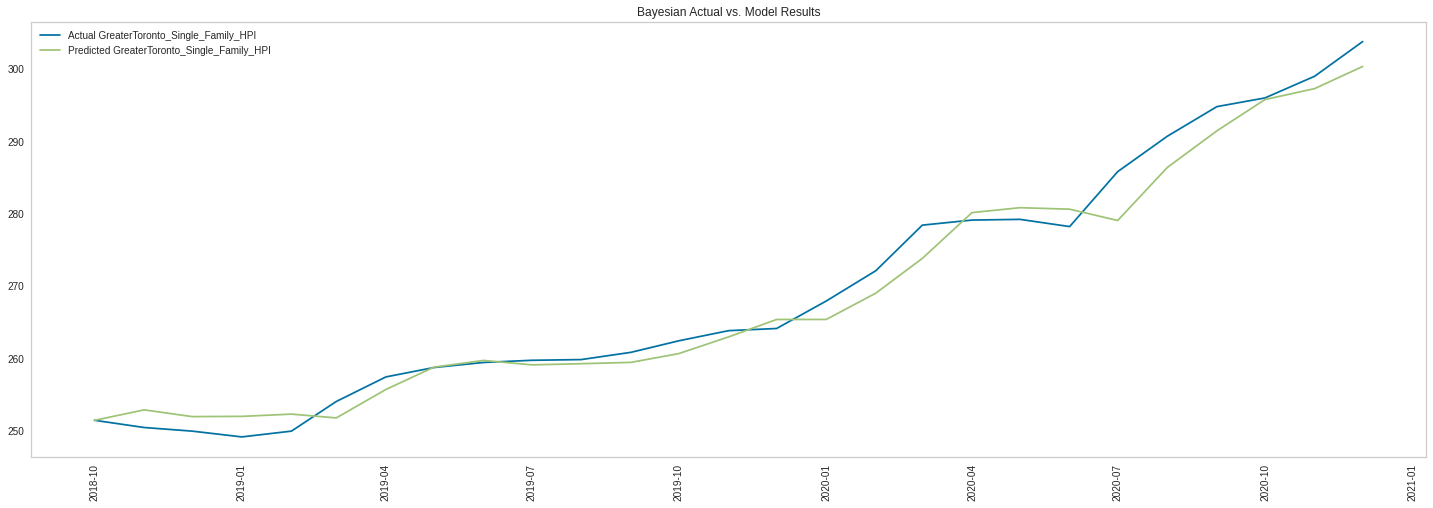

In [115]:
df_test_results = predict_test_values(model, X_test_final, y_test, X_test_date, X_train_final, y_train)
plt.rcParams["figure.figsize"] = (25,8)
plot_test_results(df_test_results, model_num)

In [116]:
print ('Columns to use for Feature Selection Slides')
X_train_final.columns

Columns to use for Feature Selection Slides


Index(['1M_Lag', 'Year', '1M_BankRate_Canada', '1M_Avg_Temperature',
       '1M_Snow_onGround', '1Yr_Toronto_ConstructionCompletionsUnits',
       '1M_Toronto_ConstructionStartsUnits', '1Yr_Snow_onGround',
       '1Yr_Toronto_ConstructionStartsUnits',
       '1M_Toronto_ConstructionCompletionsUnits',
       '1M_Toronto_UnempRate_15_54_yrs'],
      dtype='object')

In [117]:
pd.DataFrame(list(zip(X_train_final.columns,model.coef_))).to_csv('bayesian_feature_selection_coef2.csv')

In [118]:
model.intercept_

0.0

In [119]:
list(zip(X_train_final.columns,model.coef_))

[('1M_Lag', 1.002434240549455),
 ('Year', -0.0005381551593330869),
 ('1M_BankRate_Canada', -0.21634797248952964),
 ('1M_Avg_Temperature', -0.11303943819163464),
 ('1M_Snow_onGround', -0.09952532462555297),
 ('1Yr_Toronto_ConstructionCompletionsUnits', 9.633416711210194e-05),
 ('1M_Toronto_ConstructionStartsUnits', 0.00015486242856399546),
 ('1Yr_Snow_onGround', -0.2476875943590784),
 ('1Yr_Toronto_ConstructionStartsUnits', 0.0002901552880714142),
 ('1M_Toronto_ConstructionCompletionsUnits', 0.0002338649685709182),
 ('1M_Toronto_UnempRate_15_54_yrs', 0.12396726937095082)]